In [5]:
import sys
import os
import pathlib
import json
import pyvista as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


working_dir = pathlib.Path(os.path.abspath(""))
sys.path.append(str(working_dir.parent))
from util import find_runs  # noqa: E402

### Load data and calculate error

In [6]:
def load_data(runs_dir: pathlib.Path) -> pd.DataFrame:
    """Load the data from the runs in the given directory.
    Calculate the position error between timestep 0 and 2000

    Args:
        runs_dir: The directory containing the runs.
        timestep: The timestep to load.

    Return:
        A pandas DataFrame containing the data. The index is the grid spacing and
        the columns are the different mappings.
    """

    # Find the runs, we are interested in
    runs = find_runs(runs_dir)

    # Load the data
    data = {}  # Raw data: {grid_spacing: {timestep: error_value}}

    for run_path in runs:
        # Read parameters of the run
        with open(run_path / "parameters.json") as file:
            parameters = json.load(file)

        # we are only interested in the finest grid for this plot
        if parameters["refinement"] != 7:
            continue

        # Generate descriptive column name
        column_name = {
            "nearest-neighbor": "NN",
            "rbf-pum-direct": "RBF",
        }[parameters["mapping"]]

        if parameters["mapping"] == "rbf-pum-direct":
            column_name += (
                " "
                + {
                    "compact-polynomial-c0": "CP0",
                    "compact-polynomial-c2": "CP2",
                    "compact-polynomial-c4": "CP4",
                    "compact-polynomial-c6": "CP6",
                    "compact-polynomial-c8": "CP8",
                }[parameters["basis_function"]]
            )
            # column_name += f"_{parameters['support_radius']}"

        # Calculate position error
        try:
            file_name_begin = f"refinement-{parameters['refinement']}_particles_000000.pvtu"
            file_name_end = f"refinement-{parameters['refinement']}_particles_999999.pvtu"

            mesh_begin = pv.read(run_path / "solution" / file_name_begin)
            mesh_end = pv.read(run_path / "solution" / file_name_end)

            mesh_end["error"] = np.linalg.norm(mesh_begin.points - mesh_end.points, axis=1)

            mean_error = mesh_end["error"].mean()

        except Exception:
            mean_error = np.nan

        # Insert error into data dict
        if column_name not in data:
            data[column_name] = {}
        data[column_name][parameters["time_step"]] = mean_error

    # Convert data dict to pandas DataFrame
    return (
        pd.DataFrame(data)
        .sort_index(axis=0, ascending=False)
        .sort_index(axis=1, ascending=False)
    )


df = load_data(working_dir)
df

,NN
0.10000,0.161004
0.01000,0.068555
0.00100,0.018986
0.00010,0.002584
0.00001,0.000983


### Tracking error vs. time step for different grid spacings

In [7]:
def load_data(runs_dir: pathlib.Path) -> pd.DataFrame:
    """Load the data from the runs in the given directory.
    Calculate the position error between timestep 0 and 2000

    Args:
        runs_dir: The directory containing the runs.
        timestep: The timestep to load.

    Return:
        A pandas DataFrame containing the data. The index is the grid spacing and
        the columns are the different mappings.
    """

    # Find the runs, we are interested in
    runs = find_runs(runs_dir)

    # Load the data
    data = {}  # Raw data: {grid_spacing: {timestep: error_value}}

    for run_path in runs:
        # Read parameters of the run
        with open(run_path / "parameters.json") as file:
            parameters = json.load(file)

        if parameters["refinement"] not in [3, 5, 7]:
            continue

        # Calculate position error
        try:
            file_name_begin = f"refinement-{parameters['refinement']}_particles_000000.pvtu"
            file_name_end = f"refinement-{parameters['refinement']}_particles_999999.pvtu"

            mesh_begin = pv.read(run_path / "solution" / file_name_begin)
            mesh_end = pv.read(run_path / "solution" / file_name_end)

            mesh_end["error"] = np.linalg.norm(mesh_begin.points - mesh_end.points, axis=1)

            mean_error = mesh_end["error"].mean()

        except Exception:
            mean_error = np.nan

        # Insert error into data dict
        if parameters["refinement"] not in data:
            data[parameters["refinement"]] = {}
        data[parameters["refinement"]][parameters["time_step"]] = mean_error

    # Convert data dict to pandas DataFrame
    return (
        pd.DataFrame(data)
        .sort_index(axis=0, ascending=False)
        .sort_index(axis=1, ascending=False)
    )


df2 = load_data(working_dir / "euler_explicit" / "nearest-neighbor")
df2

,7,5,3
0.10000,0.161004,0.161378,0.181745
0.01000,0.068555,0.068870,0.077026
0.00100,0.018986,0.022096,0.057395
0.00010,0.002584,0.013071,0.053524
0.00001,0.000983,0.013043,0.055364


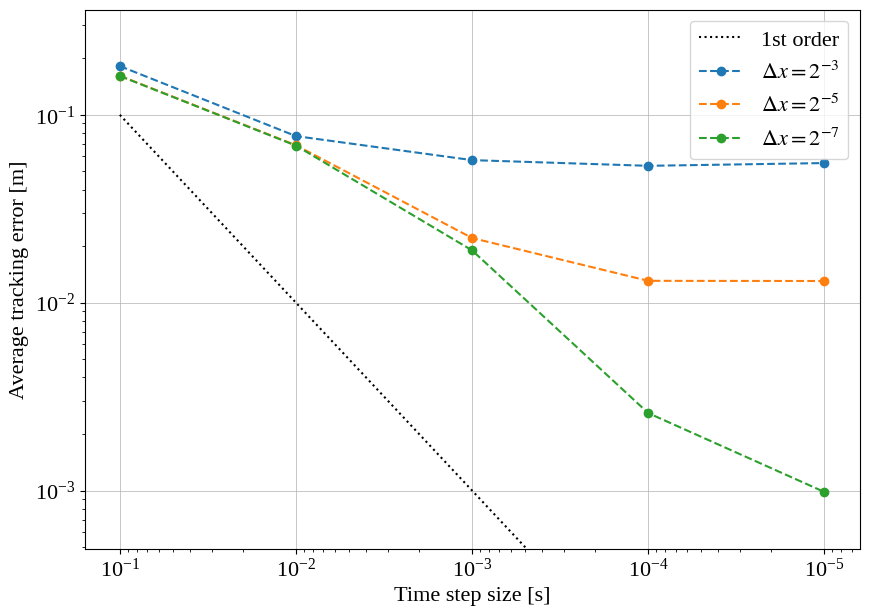

In [8]:
from matplotlib.axes import Axes


def plot_error_vs_time_step(data: pd.DataFrame, title: str, reference_lines = True, ax: Axes = None):
    """Plot the velocity error at a given timestep over different grid resolutions.
    
    Args:
        fig
        data: A DataFrame containing the error data. The index should be the grid
            resolution. Each column will be plotted as a separate line. 
        title: Title of the plot.
        reference_lines: If True, plot reference lines for first and second order
            convergence.
        ax: The axes to plot on. If None, create a new figure and axes.
    """

    # Create figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 7))
        plt.rcParams.update({
            "font.family": "serif",
            "font.serif": ["Liberation Serif"],
            "mathtext.fontset": "stix",
            "font.size": 16,
            "axes.labelsize": 16,
            "axes.titlesize": 16,
            "xtick.labelsize": 16,
            "ytick.labelsize": 16,
            "legend.fontsize": 16,
            "xtick.color": "black",
            "ytick.color": "black",
            "axes.labelcolor": "black",            
        })

    # Plot reference lines
    if reference_lines:
        # First order convergence
        ax.plot(data.index, data.index, linestyle="dotted", color="black", label="1st order")
        # Second order convergence
        # ax.plot(data.index, data.index ** 2, linestyle="dotted", color="black", label="2nd order")

    # Plot the data
    ax.plot(data.index, data[3], label=r"$\Delta x = 2^{-3}$", marker="o", linestyle="--")
    ax.plot(data.index, data[5], label=r"$\Delta x = 2^{-5}$", marker="o", linestyle="--")
    ax.plot(data.index, data[7], label=r"$\Delta x = 2^{-7}$", marker="o", linestyle="--")

    # Add labels and legend
    # ax.set_title(title, fontsize=24)
    ax.legend()
    ax.grid(linewidth=0.5)
    ax.tick_params(axis='both', which='major')
    ax.tick_params(axis='both', which='minor')

    # Configure axes
    ax.set_xlabel("Time step size [s]")
    ax.set_xscale("log")
    ax.invert_xaxis()
    
    ax.set_ylabel("Average tracking error [m]",)
    ax.set_yscale("log")
    ax.set_ylim(data.min().min() / 2, data.max().max() * 2)

    # output as pdf
    fig.savefig(working_dir / "vortex_tracing_tracking_error_vs_time_step_and_grid_spacing.pdf", bbox_inches="tight")

plot_error_vs_time_step(df2, "Tracking error converges over time step")